In [1]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings
import wandb


from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

Current device is: cuda


In [2]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.19.1
transformers.__version__: 4.41.2


In [3]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 16
    BATCH_SIZE_VALID = 8
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 1e-5
    ENCODER_LR = 1e-5
    EPOCHS = 5
    EPS = 1e-6
    FOLDS = 7
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=1000
    MAX_LEN = 512
    MIN_LR = 1e-6
    MODEL = "microsoft/deberta-v3-base"
    NUM_CYCLES = 0.5
    NUM_CLASSES = 1
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = 0 #multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'cosine' # ['linear', 'cosine']
    SEED = 42
    TRAIN = True
    TRAIN_FOLDS = [6]
    WEIGHT_DECAY = 0.05


class paths:
    OUTPUT_DIR = "/kaggle/working/output"
    TEST_CSV = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
    TRAIN_CSV = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv"


if config.DEBUG:
    config.EPOCHS = 2
    config.TRAIN_FOLDS = [3]

In [4]:
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler


def get_score(y_true, y_pred):
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def sep():
    print("-"*100)


LOGGER = get_logger()
seed_everything(seed=config.SEED)

In [5]:
train_df = pd.read_csv("/kaggle/input/ljfdlsf/train2.csv", sep=',')
#prompt = pd.read_csv("//kaggle/input/pfpfdd/predicted_prompt (1).csv")
#merged_df = train_df.merge(prompt[['essay_id', 'prompt_name']], on='essay_id', how='left')
#train_df['prompt'] = merged_df['prompt_name']
#test_df = pd.read_csv("/kaggle/input/asjdadka/test2.csv", sep=',')
print(f"Train dataframe has shape: {train_df.shape}"), sep()
#print(f"Test dataframe has shape: {test_df.shape}"), sep()
display(train_df.head())
#display(test_df.head())
small = False
if small:
    train_df = train_df[:small]

Train dataframe has shape: (17307, 3)
----------------------------------------------------------------------------------------------------


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [6]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

train_df["fold"] = -1
X = train_df["full_text"]
y = train_df["score"]
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    train_df.loc[val_index, "fold"] = i

print(train_df["fold"].value_counts())

fold
1    2473
0    2473
2    2473
5    2472
4    2472
3    2472
6    2472
Name: count, dtype: int64


In [7]:
from tokenizers import AddedToken

In [8]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken("\n\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("
", rstrip=False, lstrip=F

  0%|          | 0/17307 [00:00<?, ?it/s]

max_len: 9825


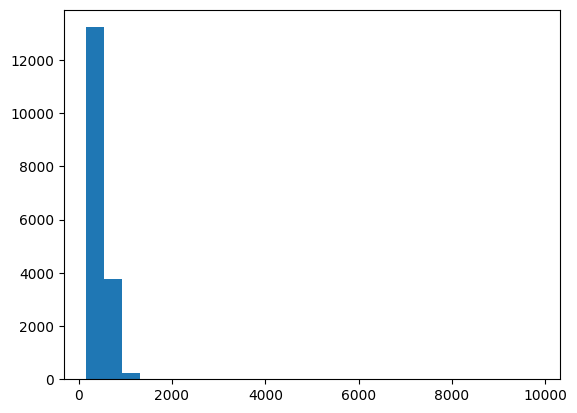

In [9]:
lengths = []
tqdm_loader = tqdm(train_df['full_text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)

config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)
config.MAX_LEN = 1024

In [10]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text,
        return_tensors=None,
        add_special_tokens=True,
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch.
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df['score'].values
        self.tokenizer = tokenizer
        self.essay_ids = df['essay_id'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.float) # TODO: check dtypes
        output["essay_ids"] = self.essay_ids[item]
        return output

In [11]:
if config.DEBUG:
    # ======== SPLIT ==========
    fold = 0
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    persuade_fold = persuade[persuade["score"].isin([1,5,6])]
    train_folds = pd.concat((train_folds,persuade_fold),axis=0)
    
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds["score"].values

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # === Let's check one sample ===
    sample = train_dataset[0]
    print(f"Encoding keys: {sample.keys()} \n")
    print(sample)

In [12]:
import timm
timm.create_model("resnet18",pretrained = True)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [13]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class AttentionPool(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1)
        )

    def forward(self, x, mask):
        w = self.attention(x).float() #
        w[mask==0]=float('-inf')
        w = torch.softmax(w,1)
        x = torch.sum(w * x, dim=1)
        return x 

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        # Load config by inferencing it from the model name.
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            #self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            #self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)

        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()

        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = AttentionPool(768)
        self.fc = nn.Linear(self.config.hidden_size, config.NUM_CLASSES)
        self._init_weights(self.fc)
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        
    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        feature = self.layer_norm1(feature)
        output = self.fc(feature)
        return output


In [14]:
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0
    train_preddd = []
    train_tar = []
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                y_preds = y_preds.view(batch_size)
                #print((y_preds,labels))
                #print(torch.clip(y_preds,1,6).round())
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            
            train_preddd.extend(y_preds.cpu().detach().numpy().tolist())
            train_tar.extend(labels.cpu().detach().numpy().tolist())

            overall_kappa = cohen_kappa_score(
                np.array(train_tar),
                np.array(train_preddd).clip(1, 6).round(),
                weights="quadratic"
            )
            
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
            
            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      'kappa:{fuckme:.4f}'
                      .format(epoch+1, step, len(train_loader),
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0],
                              fuckme = overall_kappa
                             ))

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    train_preddd = []
    train_tar = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            student_ids = batch.pop("essay_ids")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            train_preddd.extend(y_preds.cpu().detach().numpy().tolist())
            train_tar.extend(labels.cpu().detach().numpy().tolist())

            overall_kappa = cohen_kappa_score(
                np.array(train_tar),
                np.array(train_preddd).clip(1, 6).round(),
                weights="quadratic"
            )
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'kappa: {ksss:.4f}'
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader)),
                              ksss = overall_kappa
                             ))

    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["essay_ids"] = student_ids
    return losses.avg, prediction_dict

In [17]:
train_df[train_df["fold"]==0]["score"].value_counts()

score
3    898
2    675
4    560
1    179
5    139
6     22
Name: count, dtype: int64

In [18]:
import matplotlib.pyplot as plt

In [19]:
def train_loop(folds, fold):

    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    print(train_folds.shape)
    #persuade_fold = persuade[persuade["score"].isin([1,5,6])]
    #train_folds = pd.concat((train_folds,persuade_fold),axis=0).reset_index(drop=True)
    #print("train_length = ",len(train_folds))
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds["score"].values
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)

    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=False)

    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR,
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(
        optimizer_parameters,
        lr=config.ENCODER_LR,
        eps=config.EPS,
        betas=config.BETAS
    )


    num_train_steps = int(len(train_folds) / config.BATCH_SIZE_TRAIN * config.EPOCHS)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    # ======= LOSS ==========
    criterion = RMSELoss(reduction="mean") 
    # nn.SmoothL1Loss(reduction='mean')
    #criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        #print(predictions)
        predictions = predictions.clip(1,6).round()

        # ======= SCORING ==========
        score = get_score(valid_labels, predictions)
        matrix = confusion_matrix(valid_labels,predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot()
        plt.show()
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")

    predictions = torch.load(paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth",
                             map_location=torch.device('cpu'))['predictions']
    valid_folds["pred_score"] = predictions

    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds

========== Fold: 6 training ==========


(14835, 4)


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Train:   0%|          | 0/927 [00:00<?, ?train_batch/s]

Epoch: [1][0/927] Elapsed 0m 4s (remain 67m 56s) Loss: 3.1928 Grad: inf  LR: 0.00001000  kappa:0.0000
Epoch: [1][20/927] Elapsed 1m 9s (remain 50m 9s) Loss: 2.2397 Grad: 13656.4697  LR: 0.00001000  kappa:0.0252
Epoch: [1][40/927] Elapsed 2m 11s (remain 47m 11s) Loss: 1.5052 Grad: 17927.4707  LR: 0.00001000  kappa:0.0830
Epoch: [1][60/927] Elapsed 3m 16s (remain 46m 23s) Loss: 1.1963 Grad: 23559.3340  LR: 0.00001000  kappa:0.2168
Epoch: [1][80/927] Elapsed 4m 18s (remain 45m 2s) Loss: 1.0528 Grad: 42829.8828  LR: 0.00000999  kappa:0.2993
Epoch: [1][100/927] Elapsed 5m 27s (remain 44m 36s) Loss: 0.9699 Grad: nan  LR: 0.00000999  kappa:0.3505
Epoch: [1][120/927] Elapsed 6m 24s (remain 42m 38s) Loss: 0.9091 Grad: 15053.5176  LR: 0.00000998  kappa:0.3820
Epoch: [1][140/927] Elapsed 7m 27s (remain 41m 35s) Loss: 0.8583 Grad: 16640.5996  LR: 0.00000998  kappa:0.4309
Epoch: [1][160/927] Elapsed 8m 30s (remain 40m 28s) Loss: 0.8153 Grad: 7348.7192  LR: 0.00000997  kappa:0.4616
Epoch: [1][180/92

Validation:   0%|          | 0/309 [00:00<?, ?valid_batch/s]

EVAL: [0/309] Elapsed 0m 0s (remain 1m 8s) Loss: 0.9520 kappa: 0.7000
EVAL: [20/309] Elapsed 0m 8s (remain 1m 51s) Loss: 1.0652 kappa: 0.8040
EVAL: [40/309] Elapsed 0m 15s (remain 1m 40s) Loss: 1.0407 kappa: 0.8044
EVAL: [60/309] Elapsed 0m 22s (remain 1m 30s) Loss: 1.0228 kappa: 0.7920
EVAL: [80/309] Elapsed 0m 29s (remain 1m 23s) Loss: 1.0062 kappa: 0.7892
EVAL: [100/309] Elapsed 0m 37s (remain 1m 17s) Loss: 1.0239 kappa: 0.7949
EVAL: [120/309] Elapsed 0m 45s (remain 1m 11s) Loss: 1.0303 kappa: 0.7926
EVAL: [140/309] Elapsed 0m 52s (remain 1m 2s) Loss: 1.0385 kappa: 0.7981
EVAL: [160/309] Elapsed 1m 0s (remain 0m 55s) Loss: 1.0308 kappa: 0.7962
EVAL: [180/309] Elapsed 1m 8s (remain 0m 48s) Loss: 1.0278 kappa: 0.7922
EVAL: [200/309] Elapsed 1m 16s (remain 0m 40s) Loss: 1.0246 kappa: 0.7950
EVAL: [220/309] Elapsed 1m 23s (remain 0m 33s) Loss: 1.0236 kappa: 0.7969
EVAL: [240/309] Elapsed 1m 31s (remain 0m 25s) Loss: 1.0263 kappa: 0.7958
EVAL: [260/309] Elapsed 1m 40s (remain 0m 18s) Los

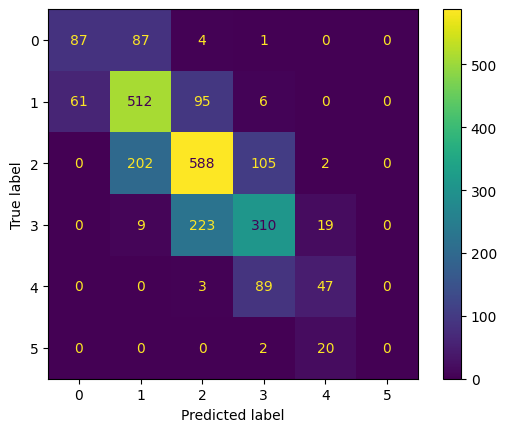

Epoch 1 - avg_train_loss: 0.5437  avg_val_loss: 1.0292  time: 3003s
Epoch 1 - Score: 0.7943
Epoch 1 - Save Best Score: 0.7943 Model


Train:   0%|          | 0/927 [00:00<?, ?train_batch/s]

Epoch: [2][0/927] Elapsed 0m 3s (remain 47m 51s) Loss: 0.3735 Grad: 391461.6250  LR: 0.00000904  kappa:0.7333
Epoch: [2][20/927] Elapsed 1m 10s (remain 50m 33s) Loss: 0.4854 Grad: 33752.4414  LR: 0.00000900  kappa:0.7827
Epoch: [2][40/927] Elapsed 2m 11s (remain 47m 17s) Loss: 0.4665 Grad: 83831.8906  LR: 0.00000896  kappa:0.7949
Epoch: [2][60/927] Elapsed 3m 9s (remain 44m 49s) Loss: 0.4609 Grad: 83666.4766  LR: 0.00000892  kappa:0.7984
Epoch: [2][80/927] Elapsed 4m 17s (remain 44m 48s) Loss: 0.4526 Grad: 39585.3438  LR: 0.00000888  kappa:0.8038
Epoch: [2][100/927] Elapsed 5m 25s (remain 44m 24s) Loss: 0.4476 Grad: 95481.5859  LR: 0.00000883  kappa:0.8056
Epoch: [2][120/927] Elapsed 6m 27s (remain 43m 1s) Loss: 0.4448 Grad: 49557.9297  LR: 0.00000879  kappa:0.8059
Epoch: [2][140/927] Elapsed 7m 27s (remain 41m 31s) Loss: 0.4377 Grad: 28227.0742  LR: 0.00000875  kappa:0.8057
Epoch: [2][160/927] Elapsed 8m 28s (remain 40m 17s) Loss: 0.4367 Grad: 82120.6719  LR: 0.00000870  kappa:0.8064


Validation:   0%|          | 0/309 [00:00<?, ?valid_batch/s]

EVAL: [0/309] Elapsed 0m 0s (remain 1m 6s) Loss: 0.9671 kappa: 0.7000
EVAL: [20/309] Elapsed 0m 8s (remain 1m 51s) Loss: 1.0691 kappa: 0.8204
EVAL: [40/309] Elapsed 0m 15s (remain 1m 40s) Loss: 1.0411 kappa: 0.8194
EVAL: [60/309] Elapsed 0m 22s (remain 1m 30s) Loss: 1.0228 kappa: 0.8024
EVAL: [80/309] Elapsed 0m 29s (remain 1m 23s) Loss: 1.0069 kappa: 0.8000
EVAL: [100/309] Elapsed 0m 37s (remain 1m 17s) Loss: 1.0278 kappa: 0.8054
EVAL: [120/309] Elapsed 0m 45s (remain 1m 11s) Loss: 1.0327 kappa: 0.8064
EVAL: [140/309] Elapsed 0m 52s (remain 1m 3s) Loss: 1.0395 kappa: 0.8127
EVAL: [160/309] Elapsed 1m 1s (remain 0m 56s) Loss: 1.0333 kappa: 0.8082
EVAL: [180/309] Elapsed 1m 8s (remain 0m 48s) Loss: 1.0296 kappa: 0.8066
EVAL: [200/309] Elapsed 1m 16s (remain 0m 41s) Loss: 1.0263 kappa: 0.8088
EVAL: [220/309] Elapsed 1m 23s (remain 0m 33s) Loss: 1.0247 kappa: 0.8090
EVAL: [240/309] Elapsed 1m 31s (remain 0m 25s) Loss: 1.0269 kappa: 0.8073
EVAL: [260/309] Elapsed 1m 40s (remain 0m 18s) Los

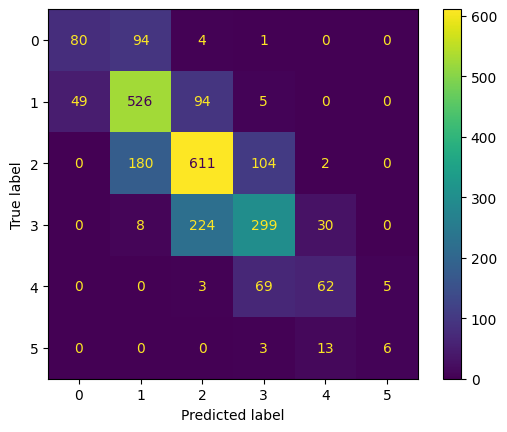

Epoch 2 - avg_train_loss: 0.4211  avg_val_loss: 1.0315  time: 3015s
Epoch 2 - Score: 0.8059
Epoch 2 - Save Best Score: 0.8059 Model


Train:   0%|          | 0/927 [00:00<?, ?train_batch/s]

Epoch: [3][0/927] Elapsed 0m 4s (remain 67m 5s) Loss: 0.3010 Grad: inf  LR: 0.00000654  kappa:0.8710
Epoch: [3][20/927] Elapsed 1m 12s (remain 52m 10s) Loss: 0.3798 Grad: 34162.1758  LR: 0.00000648  kappa:0.8481
Epoch: [3][40/927] Elapsed 2m 16s (remain 49m 18s) Loss: 0.3857 Grad: 54993.7617  LR: 0.00000641  kappa:0.8568
Epoch: [3][60/927] Elapsed 3m 20s (remain 47m 28s) Loss: 0.3772 Grad: 18615.0254  LR: 0.00000635  kappa:0.8553
Epoch: [3][80/927] Elapsed 4m 19s (remain 45m 9s) Loss: 0.3800 Grad: 40584.5977  LR: 0.00000628  kappa:0.8505
Epoch: [3][100/927] Elapsed 5m 15s (remain 43m 2s) Loss: 0.3832 Grad: 22867.8633  LR: 0.00000622  kappa:0.8493
Epoch: [3][120/927] Elapsed 6m 18s (remain 41m 59s) Loss: 0.3827 Grad: 13441.2734  LR: 0.00000615  kappa:0.8517
Epoch: [3][140/927] Elapsed 7m 15s (remain 40m 27s) Loss: 0.3808 Grad: 20641.8906  LR: 0.00000608  kappa:0.8522
Epoch: [3][160/927] Elapsed 8m 13s (remain 39m 8s) Loss: 0.3831 Grad: 29366.7930  LR: 0.00000602  kappa:0.8465
Epoch: [3]

Validation:   0%|          | 0/309 [00:00<?, ?valid_batch/s]

EVAL: [0/309] Elapsed 0m 0s (remain 1m 5s) Loss: 0.9510 kappa: 0.8367
EVAL: [20/309] Elapsed 0m 8s (remain 1m 51s) Loss: 1.0661 kappa: 0.8207
EVAL: [40/309] Elapsed 0m 15s (remain 1m 40s) Loss: 1.0396 kappa: 0.8135
EVAL: [60/309] Elapsed 0m 22s (remain 1m 30s) Loss: 1.0208 kappa: 0.8006
EVAL: [80/309] Elapsed 0m 29s (remain 1m 23s) Loss: 1.0044 kappa: 0.8019
EVAL: [100/309] Elapsed 0m 37s (remain 1m 17s) Loss: 1.0246 kappa: 0.8118
EVAL: [120/309] Elapsed 0m 45s (remain 1m 11s) Loss: 1.0310 kappa: 0.8126
EVAL: [140/309] Elapsed 0m 52s (remain 1m 2s) Loss: 1.0384 kappa: 0.8191
EVAL: [160/309] Elapsed 1m 0s (remain 0m 55s) Loss: 1.0313 kappa: 0.8153
EVAL: [180/309] Elapsed 1m 8s (remain 0m 48s) Loss: 1.0274 kappa: 0.8161
EVAL: [200/309] Elapsed 1m 16s (remain 0m 40s) Loss: 1.0235 kappa: 0.8191
EVAL: [220/309] Elapsed 1m 23s (remain 0m 33s) Loss: 1.0221 kappa: 0.8196
EVAL: [240/309] Elapsed 1m 31s (remain 0m 25s) Loss: 1.0242 kappa: 0.8176
EVAL: [260/309] Elapsed 1m 40s (remain 0m 18s) Los

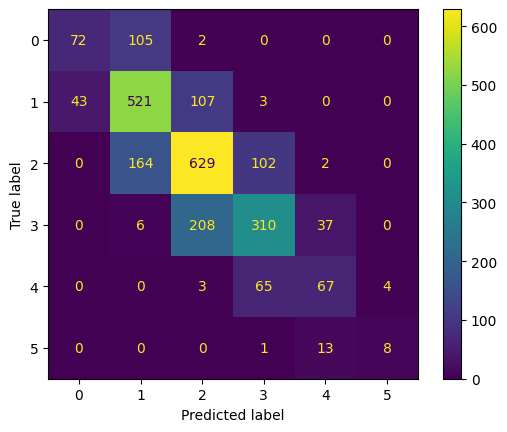

Epoch 3 - avg_train_loss: 0.3978  avg_val_loss: 1.0287  time: 3015s
Epoch 3 - Score: 0.8167
Epoch 3 - Save Best Score: 0.8167 Model


Train:   0%|          | 0/927 [00:00<?, ?train_batch/s]

Epoch: [4][0/927] Elapsed 0m 2s (remain 40m 41s) Loss: 0.3231 Grad: inf  LR: 0.00000345  kappa:0.9149
Epoch: [4][20/927] Elapsed 1m 5s (remain 46m 48s) Loss: 0.3497 Grad: 53534.2773  LR: 0.00000339  kappa:0.8797
Epoch: [4][40/927] Elapsed 2m 13s (remain 48m 7s) Loss: 0.3601 Grad: 27552.1602  LR: 0.00000332  kappa:0.8725
Epoch: [4][60/927] Elapsed 3m 12s (remain 45m 36s) Loss: 0.3550 Grad: 27133.8438  LR: 0.00000326  kappa:0.8756
Epoch: [4][80/927] Elapsed 4m 10s (remain 43m 36s) Loss: 0.3495 Grad: 31082.9297  LR: 0.00000320  kappa:0.8819
Epoch: [4][100/927] Elapsed 5m 15s (remain 43m 1s) Loss: 0.3558 Grad: 55566.2969  LR: 0.00000313  kappa:0.8773
Epoch: [4][120/927] Elapsed 6m 17s (remain 41m 51s) Loss: 0.3535 Grad: 27435.7930  LR: 0.00000307  kappa:0.8765
Epoch: [4][140/927] Elapsed 7m 14s (remain 40m 24s) Loss: 0.3559 Grad: 26925.9746  LR: 0.00000301  kappa:0.8724
Epoch: [4][160/927] Elapsed 8m 18s (remain 39m 29s) Loss: 0.3564 Grad: 51012.6484  LR: 0.00000295  kappa:0.8687
Epoch: [4

Validation:   0%|          | 0/309 [00:00<?, ?valid_batch/s]

EVAL: [0/309] Elapsed 0m 0s (remain 1m 6s) Loss: 0.9677 kappa: 0.8367
EVAL: [20/309] Elapsed 0m 8s (remain 1m 52s) Loss: 1.0812 kappa: 0.8102
EVAL: [40/309] Elapsed 0m 15s (remain 1m 40s) Loss: 1.0504 kappa: 0.8202
EVAL: [60/309] Elapsed 0m 22s (remain 1m 31s) Loss: 1.0307 kappa: 0.8068
EVAL: [80/309] Elapsed 0m 29s (remain 1m 23s) Loss: 1.0144 kappa: 0.8126
EVAL: [100/309] Elapsed 0m 37s (remain 1m 17s) Loss: 1.0346 kappa: 0.8242
EVAL: [120/309] Elapsed 0m 45s (remain 1m 11s) Loss: 1.0401 kappa: 0.8228
EVAL: [140/309] Elapsed 0m 52s (remain 1m 3s) Loss: 1.0478 kappa: 0.8300
EVAL: [160/309] Elapsed 1m 1s (remain 0m 56s) Loss: 1.0409 kappa: 0.8270
EVAL: [180/309] Elapsed 1m 8s (remain 0m 48s) Loss: 1.0377 kappa: 0.8275
EVAL: [200/309] Elapsed 1m 16s (remain 0m 41s) Loss: 1.0335 kappa: 0.8290
EVAL: [220/309] Elapsed 1m 24s (remain 0m 33s) Loss: 1.0326 kappa: 0.8282
EVAL: [240/309] Elapsed 1m 32s (remain 0m 25s) Loss: 1.0346 kappa: 0.8265
EVAL: [260/309] Elapsed 1m 40s (remain 0m 18s) Los

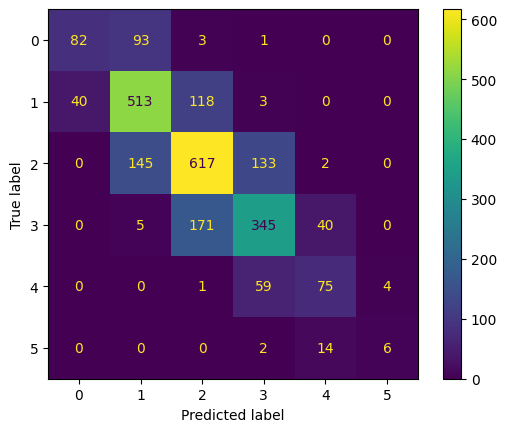

Epoch 4 - avg_train_loss: 0.3511  avg_val_loss: 1.0393  time: 3022s
Epoch 4 - Score: 0.8251
Epoch 4 - Save Best Score: 0.8251 Model


Train:   0%|          | 0/927 [00:00<?, ?train_batch/s]

Epoch: [5][0/927] Elapsed 0m 4s (remain 66m 15s) Loss: 0.2850 Grad: inf  LR: 0.00000095  kappa:0.9661
Epoch: [5][20/927] Elapsed 1m 7s (remain 48m 24s) Loss: 0.3419 Grad: 45793.8242  LR: 0.00000091  kappa:0.8964
Epoch: [5][40/927] Elapsed 2m 9s (remain 46m 30s) Loss: 0.3333 Grad: 47234.8711  LR: 0.00000087  kappa:0.8833
Epoch: [5][60/927] Elapsed 3m 10s (remain 45m 1s) Loss: 0.3295 Grad: 34450.3984  LR: 0.00000084  kappa:0.8827
Epoch: [5][80/927] Elapsed 4m 13s (remain 44m 11s) Loss: 0.3334 Grad: 42921.7969  LR: 0.00000080  kappa:0.8758
Epoch: [5][100/927] Elapsed 5m 14s (remain 42m 49s) Loss: 0.3349 Grad: 24335.1602  LR: 0.00000076  kappa:0.8769
Epoch: [5][120/927] Elapsed 6m 14s (remain 41m 35s) Loss: 0.3394 Grad: 38400.7656  LR: 0.00000073  kappa:0.8743
Epoch: [5][140/927] Elapsed 7m 19s (remain 40m 50s) Loss: 0.3384 Grad: 57953.3633  LR: 0.00000069  kappa:0.8748
Epoch: [5][160/927] Elapsed 8m 15s (remain 39m 18s) Loss: 0.3360 Grad: 22881.6699  LR: 0.00000066  kappa:0.8779
Epoch: [5

Validation:   0%|          | 0/309 [00:00<?, ?valid_batch/s]

EVAL: [0/309] Elapsed 0m 0s (remain 1m 5s) Loss: 0.9687 kappa: 0.8367
EVAL: [20/309] Elapsed 0m 8s (remain 1m 51s) Loss: 1.0775 kappa: 0.8228
EVAL: [40/309] Elapsed 0m 15s (remain 1m 40s) Loss: 1.0476 kappa: 0.8267
EVAL: [60/309] Elapsed 0m 22s (remain 1m 30s) Loss: 1.0284 kappa: 0.8131
EVAL: [80/309] Elapsed 0m 29s (remain 1m 23s) Loss: 1.0117 kappa: 0.8177
EVAL: [100/309] Elapsed 0m 37s (remain 1m 17s) Loss: 1.0319 kappa: 0.8262
EVAL: [120/309] Elapsed 0m 45s (remain 1m 11s) Loss: 1.0374 kappa: 0.8266
EVAL: [140/309] Elapsed 0m 52s (remain 1m 3s) Loss: 1.0446 kappa: 0.8324
EVAL: [160/309] Elapsed 1m 1s (remain 0m 56s) Loss: 1.0373 kappa: 0.8294
EVAL: [180/309] Elapsed 1m 8s (remain 0m 48s) Loss: 1.0343 kappa: 0.8309
EVAL: [200/309] Elapsed 1m 16s (remain 0m 41s) Loss: 1.0299 kappa: 0.8321
EVAL: [220/309] Elapsed 1m 23s (remain 0m 33s) Loss: 1.0291 kappa: 0.8316
EVAL: [240/309] Elapsed 1m 31s (remain 0m 25s) Loss: 1.0310 kappa: 0.8298
EVAL: [260/309] Elapsed 1m 40s (remain 0m 18s) Los

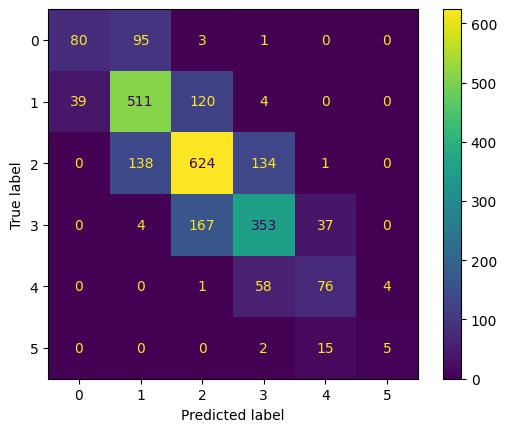

Epoch 5 - avg_train_loss: 0.3379  avg_val_loss: 1.0358  time: 3022s
Epoch 5 - Score: 0.8270
Epoch 5 - Save Best Score: 0.8270 Model
========== Fold: 6 result ==========
Score: 0.8270
========== CV ==========
Score: 0.8270


In [20]:
if __name__ == '__main__':

    def get_result(oof_df):
        labels = oof_df["score"].values
        preds = oof_df["pred_score"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')

    if config.TRAIN:
        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold in config.TRAIN_FOLDS:
                _oof_df = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)